#  Preparing the Paths

In [7]:
import numpy as np
import networkx as nx
import pandas as pd

In [ ]:
# -----------------------------# PARAMETERS# -----------------------------
rows = 4
cols = 8

# Generate nodes
rack1_nodes = list(range(1, 33))       # 1–32
rack2_nodes = list(range(101, 133))    # 101–132

all_nodes = rack1_nodes + rack2_nodes

# Mapping each node to row, col, rack
def get_position(node):
    if node <= 32:
        rack = 1
        n = node - 1

    else:
        rack = 2
        n = node - 101

    r = n // cols          # row index 0–3
    c = n % cols           # col index 0–7

    return rack, r, c


# -----------------------------# BUILD dist_matrixANCE MATRIX# -----------------------------

N = len(all_nodes)
dist_matrix_matrix = np.full((N, N), fill_value=np.inf)

# Helper: compute adjacency
def are_adjacent(n1, n2):
    r1, row1, col1 = get_position(n1)
    r2, row2, col2 = get_position(n2)

   # Case 1: Inside same rack (rook move - no diagonals)
    if r1 == r2:
        if (row1 == row2 and abs(col1 - col2) == 1) or (col1 == col2 and abs(row1 - row2) == 1):
            return True

    # Case 2: Between racks (horizontal move only)
    if r1 != r2:
        if n1 <= 32 and n1 + 100 == n2:
            return True
        if n2 <= 32 and n2 + 100 == n1:
            return True

    return False

# Fill matrix
for i, n1 in enumerate(all_nodes):
    for j, n2 in enumerate(all_nodes):
        if n1 == n2:
            dist_matrix_matrix[i][j] = 0
        elif are_adjacent(n1, n2):
            dist_matrix_matrix[i][j] = 1   # cost of one move

In [ ]:
# Set self-connection distances to infinity
np.fill_diagonal(dist_matrix, np.inf)

print("Modified distance matrix (first 5x5 block):")
print(dist_matrix[:5, :5])

In [ ]:
import sys
!{sys.executable} -m pip install python-igraph

In [ ]:
import igraph as ig

# Create a graph from the adjacency matrix
# igraph expects 0 for no edge and non-zero for edge (with weight if weighted)
# Our dist_matrix has 'inf' for no connection and '1' for connection.
# We need to convert 'inf' to 0 and '1' to 1 for igraph's Adjacency method.

# Create a boolean adjacency matrix where True means an edge exists
adj_boolean = (dist_matrix != np.inf)

# Create igraph graph from the adjacency matrix
G = ig.Graph.Adjacency(adj_boolean.tolist(), mode='undirected')

# Add node names (optional, but good for understanding)
G.vs['name'] = [str(node) for node in all_nodes]

# Plot the graph
# You can customize the layout, vertex size, label size, etc.
# For a large graph, specific layouts might be needed.
ig.plot(G, vertex_size=10, vertex_label=G.vs['name'], layout='kk', bbox=(600, 600), margin=20)

## Adjust Vertical Adjacency Costs

### Subtask:
Modify the distance matrix. For nodes that are vertically adjacent within the same rack (same column, adjacent rows), update their edge value to 4. Ensure this applies symmetrically.


**Reasoning**:
The subtask requires modifying the distance matrix for vertically adjacent nodes within the same rack. I need to iterate through all node pairs, check for the specified vertical adjacency conditions, and then update the distance matrix symmetrically with a cost of 4. Finally, I will print a segment of the updated matrix for verification.



In [ ]:
print("\n--- Applying Vertical Adjacency Cost (4) ---")

# Iterate through all unique pairs of nodes
for i, n1 in enumerate(all_nodes):
    for j, n2 in enumerate(all_nodes):
        # Skip if it's the same node or already processed (to avoid redundant checks)
        if i >= j:
            continue

        rack1, row1, col1 = get_position(n1)
        rack2, row2, col2 = get_position(n2)

        # Check for vertical adjacency within the same rack and column
        if (rack1 == rack2 and
            col1 == col2 and
            abs(row1 - row2) == 1):

            # Update the distance matrix symmetrically
            dist_matrix[i][j] = 4
            dist_matrix[j][i] = 4

print("Modified distance matrix after adjusting vertical adjacency (first 10x10 block):\n")
print(dist_matrix[:10, :10])

In [ ]:
import igraph as ig

# Create a copy of the distance matrix to modify for igraph
# Replace 'inf' values with 0 to represent no edge for igraph
weighted_adj_matrix = np.copy(dist_matrix)
weighted_adj_matrix[np.isinf(weighted_adj_matrix)] = 0

# Create igraph graph from the weighted adjacency matrix using Weighted_Adjacency
# This correctly populates the 'weight' edge attribute.
G = ig.Graph.Weighted_Adjacency(weighted_adj_matrix.tolist(), mode='undirected')

# Add node names (all_nodes is available from previous cells)
G.vs['name'] = [str(node) for node in all_nodes]

# Define edge colors based on weight for better visualization
# Weight 4 (vertical adjacency) will be red, Weight 1 (other adjacencies) will be blue
edge_weights = G.es['weight']
edge_colors = ['red' if w == 4 else 'blue' for w in edge_weights]

# Define edge widths, making higher weights visually thicker
edge_widths = [w / 2 for w in edge_weights] # Scale down for better visual distinction

# Plot the graph
print("Displaying the graph with updated edge weights (red for weight 4, blue for weight 1)...")
plot = ig.plot(G,
        vertex_size=15, # Size of the nodes
        vertex_label=G.vs['name'], # Display node names as labels
        vertex_label_size=8, # Size of the node labels
        edge_width=edge_widths, # Apply varied edge widths based on weight
        edge_color=edge_colors, # Apply varied edge colors based on weight
        layout='kk', # Kamada-Kawai layout, good for general graphs
        bbox=(800, 800), # Bounding box for the plot size
        margin=30 # Margin around the plot
)

# Explicitly display the plot
display(plot)

# ACO Algorithm

In [ ]:
n = dist_matrix.shape[0]

# Initialize pheromone matrix τ with τ0 = 1/n
tau0 = 1 / n
tau = np.full((n, n), tau0)
np.fill_diagonal(tau, 0)

# Compute heuristic matrix η = 1 / D
eta = np.zeros_like(dist_matrix)
mask = dist_matrix > 0
eta[mask] = 1 / dist_matrix[mask]
# diagonal remains zero

In [ ]:
def choose_next_node(current, visited, tau, eta, alpha=1, beta=2):
    # Convert 1-based current node to 0-based index
    i = current - 1

    all_nodes = np.arange(1, tau.shape[0] + 1)
    allowed = [node for node in all_nodes if node not in visited]

    # Convert allowed nodes (1-based) to NumPy indexes (0-based)
    allowed_idx = np.array([node - 1 for node in allowed])

    # Compute weights w_ij = tau^alpha * eta^beta
    weights = (tau[i, allowed_idx] ** alpha) * (eta[i, allowed_idx] ** beta)

    # Normalize to probabilities
    probs = weights / weights.sum()

    # Pick next node according to probabilities
    next_node = np.random.choice(allowed, p=probs)
    return next_node, probs


In [ ]:
def build_tour(start_node, tau, eta, alpha, beta):
    visited = [start_node]
    current = start_node

    while len(visited) < 6:      # for 6 nodes
        next_node, _ = choose_next_node(current, visited, tau, eta, alpha, beta)
        visited.append(next_node)
        current = next_node

    return visited


In [ ]:
# Heuristic information: η_ij = 1 / distance
# Avoid divide-by-zero on diagonal
heuristic = 1 / (dist_matrix + np.eye(n))

# Replace diagonal's wrong "1/1" with 0
np.fill_diagonal(heuristic, 0)

# Initial pheromone matrix τ_ij
pheromone = np.ones((n, n))
np.fill_diagonal(pheromone, 0)

dist_matrix, heuristic, pheromone


In [ ]:
def compute_probabilities(current_node, allowed_nodes, pheromone, heuristic, alpha, beta):
    # Extract pheromone and heuristic values for allowed nodes
    tau = pheromone[current_node, allowed_nodes] ** alpha
    eta = heuristic[current_node, allowed_nodes] ** beta

    # Numerator: tau^alpha * eta^beta
    scores = tau * eta

    # Normalize to get probabilities
    total = scores.sum()
    probabilities = scores / total
    return probabilities


In [ ]:
def choose_next_node(current_node, allowed_nodes, pheromone, heuristic, alpha, beta):
    probabilities = compute_probabilities(
        current_node, allowed_nodes, pheromone, heuristic, alpha, beta
    )
    # Choose based on probability distribution
    next_node = np.random.choice(allowed_nodes, p=probabilities)
    return next_node

In [ ]:
def build_tour(start, pheromone, alpha, beta, dist):
    tour = [start]
    unvisited = list(range(len(dist)))
    unvisited.remove(start)

    current = start
    while unvisited:
        nxt = choose_next_node(current, unvisited, pheromone, alpha, beta, dist)
        tour.append(nxt)
        unvisited.remove(nxt)
        current = nxt

    return tour

In [ ]:
def tour_cost(tour, dist):
    cost = 0.0
    for i in range(len(tour) - 1):
        cost += dist[tour[i], tour[i+1]]
    return cost

In [ ]:
def evaporate_pheromone(pheromone, rho):
    pheromone *= (1 - rho)


In [ ]:
def deposit_pheromone(pheromone, tours, dist, Q):
    # tours: list of tours, one per ant
    delta = np.zeros_like(pheromone)

    for tour in tours:
        L = tour_cost(tour, dist)
        contribution = Q / L

        for i in range(len(tour) - 1):
            a = tour[i]
            b = tour[i+1]
            delta[a, b] += contribution
            delta[b, a] += contribution

    pheromone += delta


In [ ]:
def run_iteration(pheromone, heuristic, dist, alpha, beta, rho, Q, n_ants):
    n = pheromone.shape[0]
    tours = []

    # 1) Build tours
    for _ in range(n_ants):
        start = np.random.randint(n)
        tour = build_tour(start, pheromone, heuristic, alpha, beta)
        tours.append(tour)

    # 2) Evaporation
    evaporate_pheromone(pheromone, rho)

    # 3) Deposit pheromone
    deposit_pheromone(pheromone, tours, dist, Q)

    return tours


In [ ]:
def run_aco(dist, n_ants, alpha, beta, rho, Q, iterations):
    n = dist.shape[0]

    # initialize pheromone
    pheromone = np.ones((n, n))
    heuristic = 1 / (dist + 1e-10)

    best_tour = None
    best_cost = np.inf

    for it in range(iterations):
        tours = run_iteration(pheromone, heuristic, dist,
                              alpha, beta, rho, Q, n_ants)

        # here we check each tour and update best_tour, best_cost

    return best_tour, best_cost


In [ ]:
import random
import numpy as np


# ACO parameters
num_ants = 20
num_iterations = 500
alpha = 1.0   # pheromone importance
beta = 2.0    # heuristic importance
rho = 0.4     # evaporation rate
Q = 100       # pheromone deposit constant

# Initialize pheromone
pheromone = np.ones((n, n))

# Visibility = 1 / distance (avoid division by zero)
visibility = 1 / (dist_matrix + 1e-10)
visibility[dist_matrix == 0] = 0

def choose_next_node(pheromone_row, visibility_row, visited):
    allowed = [i for i in range(len(pheromone_row)) if i not in visited]
    if not allowed:
        # This should not be reached if len(tour) < n in build_tour
        return None

    tau_allowed = np.array([pheromone_row[i] for i in allowed])
    eta_allowed = np.array([visibility_row[i] for i in allowed])

    prob_numerator = (tau_allowed ** alpha) * (eta_allowed ** beta)
    sum_prob_numerator = np.sum(prob_numerator)

    if sum_prob_numerator == 0:
        # If all potential moves have zero probability (e.g., all are infinitely far),
        # choose a random allowed node to avoid division by zero and getting stuck.
        # This might lead to an 'inf' cost tour, which is handled by best_length = float('inf').
        next_node_idx_in_allowed = random.randrange(len(allowed))
    else:
        prob = prob_numerator / sum_prob_numerator
        next_node_idx_in_allowed = random.choices(range(len(allowed)), weights=prob)[0]

    return allowed[next_node_idx_in_allowed]

def build_tour(pheromone, visibility):
    start = random.randint(0, n-1)
    tour = [start]

    while len(tour) < n:
        curr = tour[-1]
        nxt = choose_next_node(pheromone[curr], visibility[curr], tour)
        tour.append(nxt)

    return tour

def tour_length(tour):
    total = 0
    for i in range(len(tour)):
        total += dist_matrix[tour[i]][tour[(i+1) % len(tour)]]
    return total

best_tour = None
best_length = float('inf')

for iteration in range(num_iterations):

    all_tours = []
    all_lengths = []

    # Generate tours
    for _ in range(num_ants):
        tour = build_tour(pheromone, visibility)
        length = tour_length(tour)
        all_tours.append(tour)
        all_lengths.append(length)

        if length < best_length:
            best_length = length
            best_tour = tour

    # Evaporation
    pheromone = (1 - rho) * pheromone

    # Deposit pheromone
    for tour, length in zip(all_tours, all_lengths):
        if length != float('inf'): # Only deposit pheromone for valid tours
            for i in range(len(tour)):
                a = tour[i]
                b = tour[(i+1) % len(tour)]
                pheromone[a][b] += Q / length
                pheromone[b][a] += Q / length

    print(f"Iteration {iteration+1}: best length so far = {best_length}")

print("\n==== Final Result ====")
print("Best tour:", best_tour)
print("Best tour length:", best_length)


# Library try

In [ ]:
pip install aco_routing

In [ ]:
from aco_routing import ACO
import networkx as nx

In [ ]:
G = nx.DiGraph()

G.add_edge("A", "B", cost=2)
G.add_edge("B", "C", cost=2)
G.add_edge("A", "H", cost=2)
G.add_edge("H", "G", cost=2)
G.add_edge("C", "F", cost=1)
G.add_edge("F", "G", cost=1)
G.add_edge("G", "F", cost=1)
G.add_edge("F", "C", cost=1)
G.add_edge("C", "D", cost=10)
G.add_edge("E", "D", cost=2)
G.add_edge("G", "E", cost=2)

In [ ]:
aco = ACO(G, ant_max_steps=100, num_iterations=100, ant_random_spawn=True)

aco_path, aco_cost = aco.find_shortest_path(
    source="A",
    destination="D",
    num_ants=100,
)

In [ ]:
aco_path, aco_cost

## For my matrix

In [ ]:
import networkx as nx

# Create an empty graph
G_nx = nx.Graph()

# Add nodes to the graph using the original node identifiers
G_nx.add_nodes_from(all_nodes)

# Iterate through the dist_matrix to add edges and weights
for i in range(N):
    for j in range(N):
        # Get the actual node names from the all_nodes list
        node1 = all_nodes[i]
        node2 = all_nodes[j]

        # Add an edge if the distance is not infinity and it's not a self-loop
        if dist_matrix[i][j] != np.inf and i != j:
            G_nx.add_edge(node1, node2, cost=dist_matrix[i][j])

print(f"NetworkX Graph created with {G_nx.number_of_nodes()} nodes and {G_nx.number_of_edges()} edges.")

# Display some information about the graph
print("First 5 nodes:", list(G_nx.nodes())[:5])
print("First 5 edges with weights:")
for edge in list(G_nx.edges(data=True))[:5]:
    print(edge)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10)) # Adjust figure size for better visibility
pos = nx.spring_layout(G_nx, k=0.15, iterations=20) # Use spring layout for a good general visualization
nx.draw(
    G_nx,
    pos,
    with_labels=True,
    node_size=700,
    node_color="skyblue",
    font_size=8,
    font_weight="bold",
    width=0.5,
    edge_color="gray",
    alpha=0.7
)

# Add edge labels (weights)
edge_labels = nx.get_edge_attributes(G_nx, 'cost')
nx.draw_networkx_edge_labels(G_nx, pos, edge_labels=edge_labels, font_size=7, alpha=0.8)

plt.title("NetworkX Graph Visualization", size=15)
plt.show()

In [ ]:
aco = ACO(G_nx, ant_max_steps=100, num_iterations=100, ant_random_spawn=True)

aco_path, aco_cost = aco.find_shortest_path(
    source=1,
    destination=20,
    num_ants=20,
)

In [ ]:
aco_path , aco_cost

# NEW SECTION

## Import Libraries

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [9]:
# --- Start of added code to define missing variables and functions ---
rows = 4
cols = 8
rack1_nodes = list(range(1, 33))
rack2_nodes = list(range(101, 133))

def get_position(node):
    if node <= 32:
        rack = 1
        n = node - 1
    else:
        rack = 2
        n = node - 101
    r = n // cols
    c = n % cols
    return rack, r, c
# --- End of added code ---

# Helper function to convert row/col back to node ID for a specific rack
def get_node_from_rc(rack, r, c):
    if rack == 1:
        return r * cols + c + 1
    elif rack == 2:
        return r * cols + c + 101
    return None

# Create two separate graphs for Rack 1 and Rack 2
G_rack1 = nx.Graph()
G_rack2 = nx.Graph()

# Add nodes to Rack 1 graph
G_rack1.add_nodes_from(rack1_nodes)
# Add nodes to Rack 2 graph
G_rack2.add_nodes_from(rack2_nodes)

# Add edges for Rack 1
for node_id in rack1_nodes:
    _, r, c = get_position(node_id) # get_position already defined in DMM6GLZDX40N

    # Check right neighbor
    if c < cols - 1:
        neighbor_node_id = get_node_from_rc(1, r, c + 1)
        G_rack1.add_edge(node_id, neighbor_node_id, cost=1.0) # Assuming cost 1 for internal moves

    # Check down neighbor
    if r < rows - 1:
        neighbor_node_id = get_node_from_rc(1, r + 1, c)
        G_rack1.add_edge(node_id, neighbor_node_id, cost=4.0) # Assuming cost 4 for vertical moves, as per previous logic

# Add edges for Rack 2
for node_id in rack2_nodes:
    _, r, c = get_position(node_id)

    # Check right neighbor
    if c < cols - 1:
        neighbor_node_id = get_node_from_rc(2, r, c + 1)
        G_rack2.add_edge(node_id, neighbor_node_id, cost=1.0)

    # Check down neighbor
    if r < rows - 1:
        neighbor_node_id = get_node_from_rc(2, r + 1, c)
        G_rack2.add_edge(node_id, neighbor_node_id, cost=4.0)

print(f"Rack 1 Graph: {G_rack1.number_of_nodes()} nodes, {G_rack1.number_of_edges()} edges.")
print(f"Rack 2 Graph: {G_rack2.number_of_nodes()} nodes, {G_rack2.number_of_edges()} edges.")

Rack 1 Graph: 32 nodes, 52 edges.
Rack 2 Graph: 32 nodes, 52 edges.


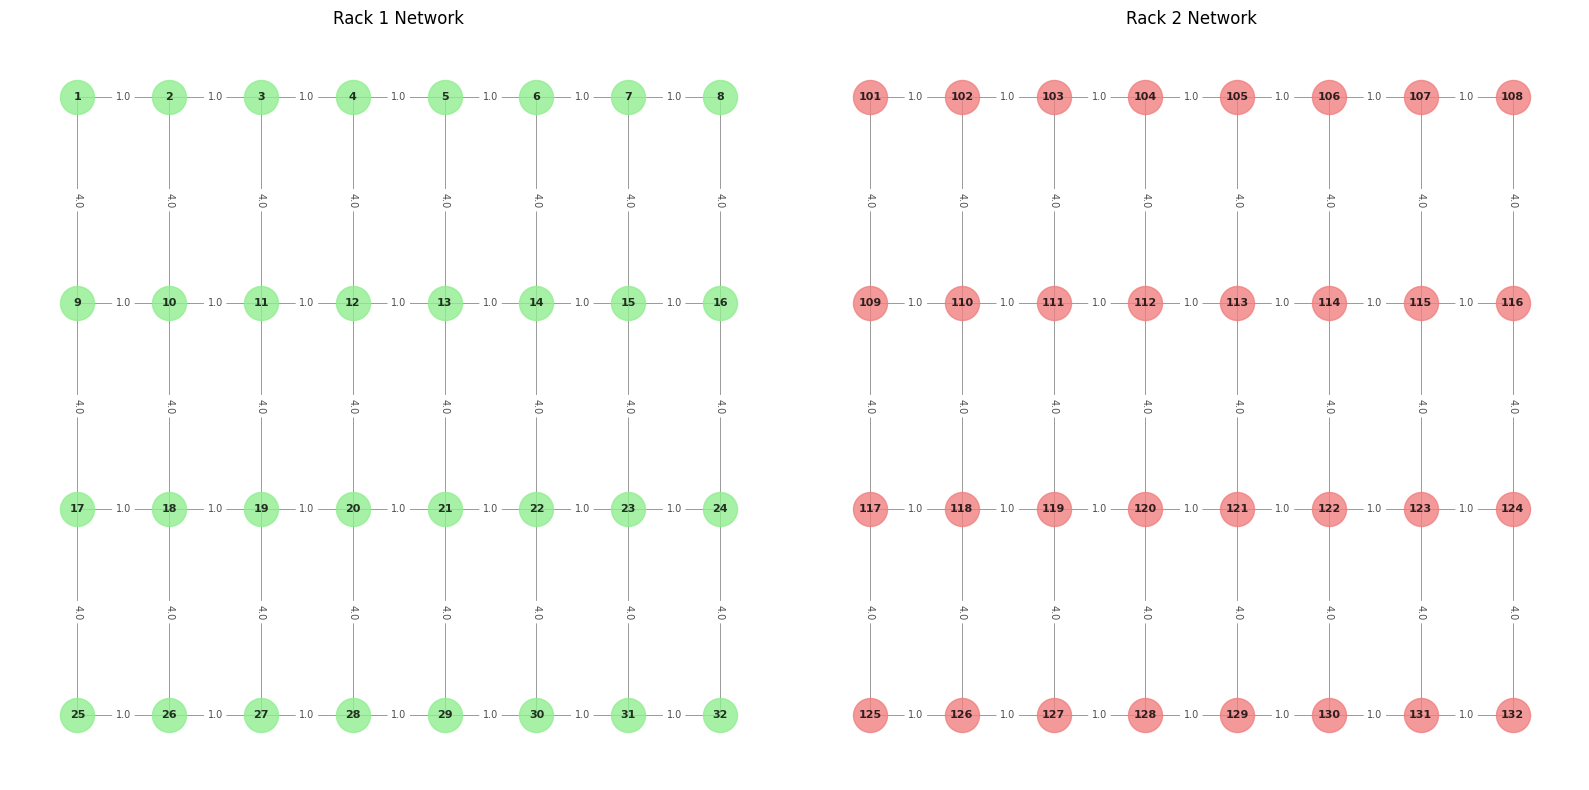

In [10]:
plt.figure(figsize=(16, 8))

# Plot Rack 1 Graph
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
pos_rack1 = nx.grid_2d_graph(rows, cols).nodes # Using grid_2d_graph for layout, then map to actual node IDs
pos_map_rack1 = {get_node_from_rc(1, r, c): (c, -r) for r, c in pos_rack1} # Invert y-axis for typical grid visualization

nx.draw(
    G_rack1,
    pos_map_rack1,
    with_labels=True,
    node_size=600,
    node_color="lightgreen",
    font_size=8,
    font_weight="bold",
    width=0.7,
    edge_color="gray",
    alpha=0.8
)
edge_labels_rack1 = nx.get_edge_attributes(G_rack1, 'cost')
nx.draw_networkx_edge_labels(G_rack1, pos_map_rack1, edge_labels=edge_labels_rack1, font_size=7, alpha=0.7)
plt.title("Rack 1 Network", size=12)

# Plot Rack 2 Graph
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
pos_rack2 = nx.grid_2d_graph(rows, cols).nodes
pos_map_rack2 = {get_node_from_rc(2, r, c): (c, -r) for r, c in pos_rack2} # Invert y-axis

nx.draw(
    G_rack2,
    pos_map_rack2,
    with_labels=True,
    node_size=600,
    node_color="lightcoral",
    font_size=8,
    font_weight="bold",
    width=0.7,
    edge_color="gray",
    alpha=0.8
)
edge_labels_rack2 = nx.get_edge_attributes(G_rack2, 'cost')
nx.draw_networkx_edge_labels(G_rack2, pos_map_rack2, edge_labels=edge_labels_rack2, font_size=7, alpha=0.7)
plt.title("Rack 2 Network", size=12)

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

Combined Graph: 64 nodes, 136 edges.


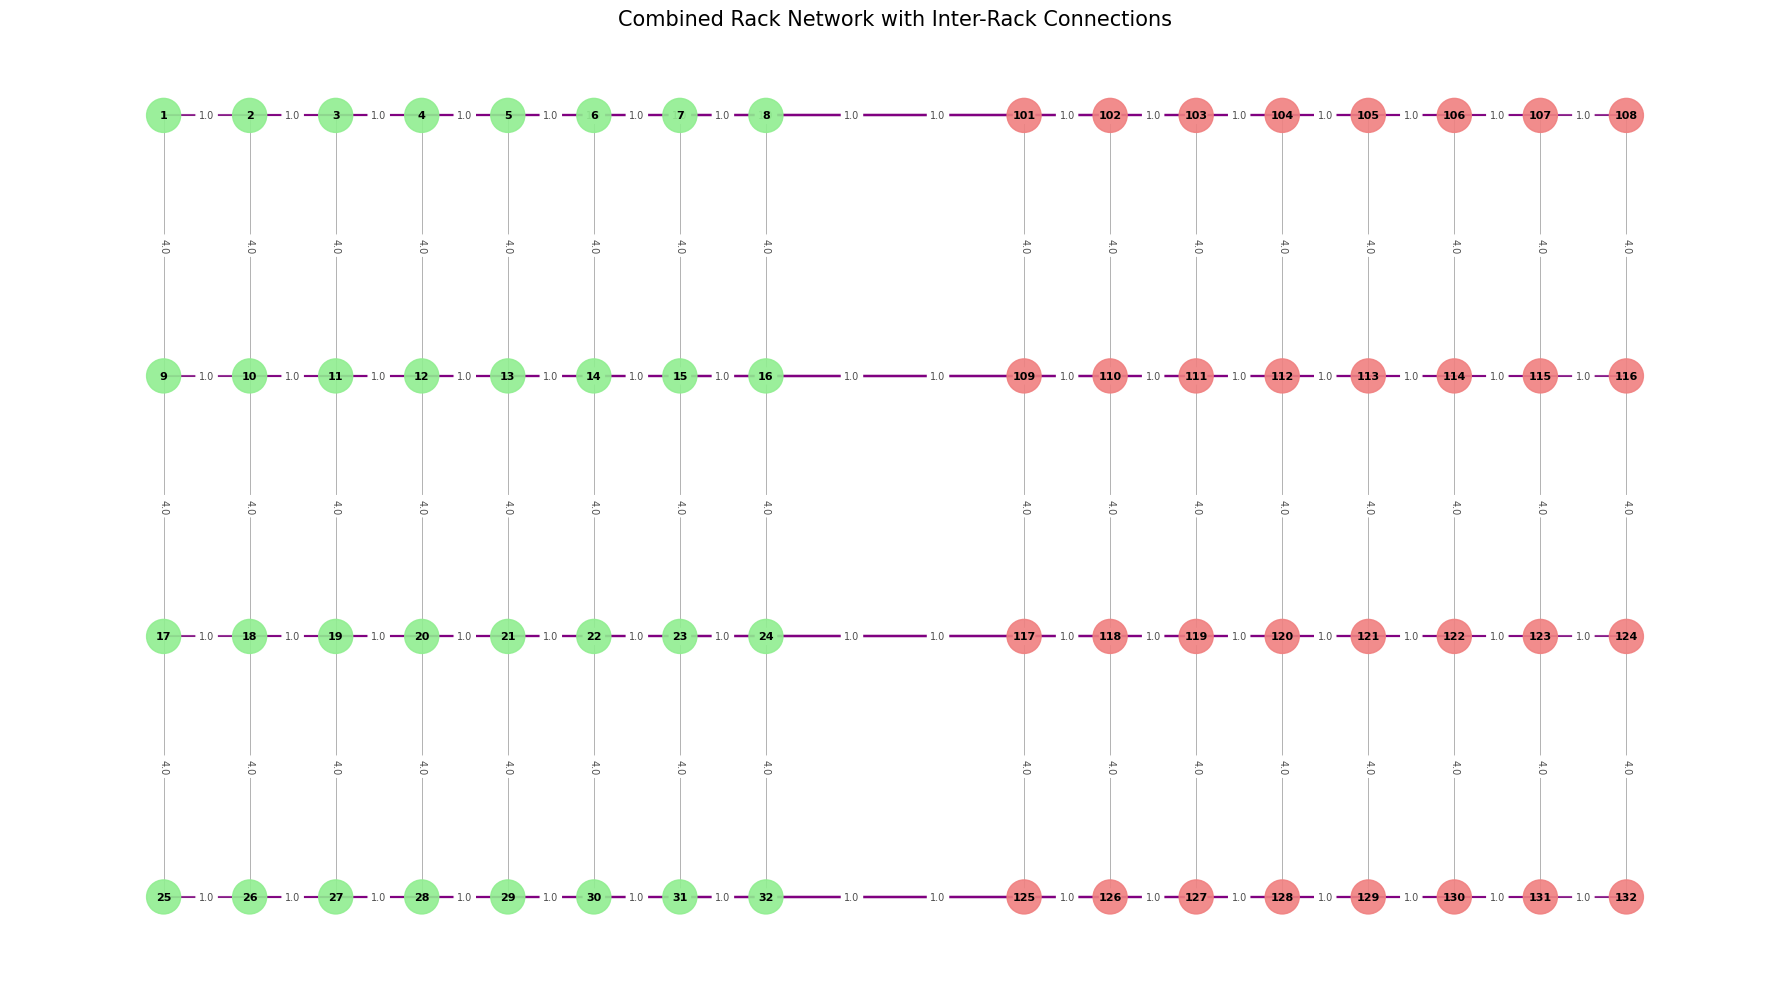

In [11]:
# Ensure all_nodes is defined
all_nodes = rack1_nodes + rack2_nodes

# Create a combined graph
G_combined = nx.Graph()

# Add all nodes from both racks
G_combined.add_nodes_from(all_nodes)

# Add edges from Rack 1 graph to the combined graph
for u, v, data in G_rack1.edges(data=True):
    G_combined.add_edge(u, v, cost=data['cost'])

# Add edges from Rack 2 graph to the combined graph
for u, v, data in G_rack2.edges(data=True):
    G_combined.add_edge(u, v, cost=data['cost'])

# Add inter-rack connections (e.g., 1-101, 2-102, etc.)
# Iterate through nodes 1-32 (rack1_nodes) and connect them to their +100 counterparts in rack2_nodes
for node_r1 in rack1_nodes:
    node_r2 = node_r1 + 100
    if node_r2 in rack2_nodes: # Ensure the corresponding node exists in rack2
        G_combined.add_edge(node_r1, node_r2, cost=1.0)

print(f"Combined Graph: {G_combined.number_of_nodes()} nodes, {G_combined.number_of_edges()} edges.")

# --- Visualization of the Combined Graph ---

plt.figure(figsize=(18, 10))

# Define positions for all nodes for a structured layout
pos = {}
# Positions for Rack 1 nodes
for node_id in rack1_nodes:
    _, r, c = get_position(node_id)
    pos[node_id] = (c, -r) # X: column, Y: negative row for top-down display

# Positions for Rack 2 nodes, offset horizontally
offset_x = cols + 2 # Some space between racks
for node_id in rack2_nodes:
    _, r, c = get_position(node_id)
    pos[node_id] = (c + offset_x, -r)

# Draw nodes
nx.draw_networkx_nodes(
    G_combined,
    pos,
    node_size=600,
    node_color=["lightgreen" if n in rack1_nodes else "lightcoral" for n in G_combined.nodes()],
    alpha=0.9
)

# Draw edges
nx.draw_networkx_edges(
    G_combined,
    pos,
    width=0.7,
    edge_color="gray",
    alpha=0.6
)

# Draw inter-rack edges separately with a distinct color
inter_rack_edges = [(u, v) for u, v, data in G_combined.edges(data=True) if data['cost'] == 1.0 and ((u in rack1_nodes and v in rack2_nodes) or (u in rack2_nodes and v in rack1_nodes))]
nx.draw_networkx_edges(
    G_combined,
    pos,
    edgelist=inter_rack_edges,
    edge_color="purple", # Highlight inter-rack connections
    width=1.5,
    alpha=0.8
)

# Draw node labels
nx.draw_networkx_labels(
    G_combined,
    pos,
    font_size=8,
    font_weight="bold"
)

# Draw edge labels (costs)
edge_labels = nx.get_edge_attributes(G_combined, 'cost')
nx.draw_networkx_edge_labels(
    G_combined,
    pos,
    edge_labels=edge_labels,
    font_size=7,
    alpha=0.7
)

plt.title("Combined Rack Network with Inter-Rack Connections", size=15)
plt.axis('off') # Hide axes
plt.tight_layout()
plt.show()

# ACO

## Task
Implement and execute an Ant Colony Optimization (ACO) algorithm to find the optimized path for a UAV. This path must start at a new UGV node `0`, end at another new UGV node `100`, and visit a predefined set of specific rack cells (e.g., `[1, 5, 10, 20, 105, 110, 120]`). The implementation should include:
1.  **Graph Preparation**: Add UGV nodes `0` and `100` to the existing `G_combined` NetworkX graph, along with edges `(0, 1, cost=1.0)` and `(100, 101, cost=1.0)`. Generate a 0-indexed `distance_matrix` from this augmented graph and create mappings between original node IDs and their 0-indexed equivalents.
2.  **ACO Parameters and Target Nodes**: Define ACO parameters (`num_ants`, `num_iterations`, `alpha`, `beta`, `rho`, `Q`), the `start_node_original` (0), the `end_node_original` (100), and a list of `required_visit_nodes_original` (e.g., `[1, 5, 10, 20, 105, 110, 120]`).
3.  **ACO Core Functions**: Implement `choose_next_node` (prioritizing required nodes, then moving towards the end node), `build_tour` (ensuring all required nodes are visited exactly once), `calculate_tour_cost`, `evaporate_pheromone`, and `deposit_pheromone`.
4.  **Execution and Reporting**: Initialize pheromone and visibility matrices, translate node IDs to 0-indexed, run the ACO loop, and print the `best_tour` (in original node IDs) and `best_cost` found. Ensure the code is well-commented.
5.  **Summary**: Provide a summary of the ACO implementation, including the start/end UGV positions, required rack cells, and the final calculated best path and its total cost.

### Prepare Graph for ACO

#### Subtask:
Add UGV nodes '0' and '100' to the 'G_combined' NetworkX graph, add specific edges, generate a 0-indexed distance matrix, and create mappings between original node IDs and their 0-indexed equivalents.


**Reasoning**:
The subtask requires adding new nodes and edges to the existing graph, then converting it into a 0-indexed distance matrix with corresponding mapping dictionaries. I will perform all these operations in a single code block to ensure consistency and efficiency.



In [12]:
# 1. Add new nodes '0' and '100' to G_combined
G_combined.add_node(0)
G_combined.add_node(100)

# 2. Add an edge between node '0' and node '1' with a cost of 1.0
G_combined.add_edge(0, 1, cost=1.0)

# 3. Add an edge between node '100' and node '101' with a cost of 1.0
G_combined.add_edge(100, 101, cost=1.0)

print(f"Updated Combined Graph: {G_combined.number_of_nodes()} nodes, {G_combined.number_of_edges()} edges.")

# 4. Get a sorted list of all unique nodes currently in G_combined
all_nodes_sorted = sorted(list(G_combined.nodes()))
N_total = len(all_nodes_sorted)

# 5. Create two dictionaries for mapping
original_to_indexed_map = {node_id: idx for idx, node_id in enumerate(all_nodes_sorted)}
indexed_to_original_map = {idx: node_id for idx, node_id in enumerate(all_nodes_sorted)}

print("\nNode Mappings:")
print(f"Original ID 0 maps to index: {original_to_indexed_map[0]}")
print(f"Original ID 1 maps to index: {original_to_indexed_map[1]}")
print(f"Original ID 100 maps to index: {original_to_indexed_map[100]}")
print(f"Original ID 101 maps to index: {original_to_indexed_map[101]}")

# 6. Initialize an N x N NumPy array named `distance_matrix`
distance_matrix_0_indexed = np.full((N_total, N_total), fill_value=np.inf)
np.fill_diagonal(distance_matrix_0_indexed, 0)

# 7. Iterate through all edges in G_combined and update the distance_matrix
for u, v, data in G_combined.edges(data=True):
    cost = data['cost']
    idx_u = original_to_indexed_map[u]
    idx_v = original_to_indexed_map[v]
    distance_matrix_0_indexed[idx_u, idx_v] = cost
    distance_matrix_0_indexed[idx_v, idx_u] = cost # Assuming undirected graph

print(f"\nGenerated 0-indexed distance matrix with shape: {distance_matrix_0_indexed.shape}")
print("First 5x5 block of the 0-indexed distance matrix:")
print(distance_matrix_0_indexed[:5, :5])

Updated Combined Graph: 66 nodes, 138 edges.

Node Mappings:
Original ID 0 maps to index: 0
Original ID 1 maps to index: 1
Original ID 100 maps to index: 33
Original ID 101 maps to index: 34

Generated 0-indexed distance matrix with shape: (66, 66)
First 5x5 block of the 0-indexed distance matrix:
[[ 0.  1. inf inf inf]
 [ 1.  0.  1. inf inf]
 [inf  1.  0.  1. inf]
 [inf inf  1.  0.  1.]
 [inf inf inf  1.  0.]]


**Reasoning**:
The subtask requires defining ACO parameters and specifying the start, end, and required visit nodes in both original and 0-indexed formats. I will define these variables in a code block and then use the `original_to_indexed_map` to convert the original node IDs to their 0-indexed counterparts.



### Parameters

In [13]:
# ACO parameters (as per task description)
num_ants = 25
num_iterations = 200
alpha = 1.0   # pheromone importance
beta = 2.3    # heuristic importance
rho = 0.1     # evaporation rate
Q = 1.0       # pheromone deposit constant

# Define target nodes (original IDs)
start_node_original = 0
end_node_original = 100
required_visit_nodes_original = [1, 8, 15, 20, 28]

# Translate original node IDs to 0-indexed IDs
start_node_indexed = original_to_indexed_map[start_node_original]
end_node_indexed = original_to_indexed_map[end_node_original]
required_visit_nodes_indexed = [original_to_indexed_map[node] for node in required_visit_nodes_original]

print("ACO Parameters:")
print(f"  Number of Ants: {num_ants}")
print(f"  Number of Iterations: {num_iterations}")
print(f"  Alpha (Pheromone Importance): {alpha}")
print(f"  Beta (Heuristic Importance): {beta}")
print(f"  Rho (Evaporation Rate): {rho}")
print(f"  Q (Pheromone Deposit Constant): {Q}")

print("\nTarget Nodes (Original IDs):")
print(f"  Start Node: {start_node_original}")
print(f"  End Node: {end_node_original}")
print(f"  Required Visit Nodes: {required_visit_nodes_original}")

print("\nTarget Nodes (0-indexed IDs):")
print(f"  Start Node: {start_node_indexed}")
print(f"  End Node: {end_node_indexed}")
print(f"  Required Visit Nodes: {required_visit_nodes_indexed}")

ACO Parameters:
  Number of Ants: 25
  Number of Iterations: 200
  Alpha (Pheromone Importance): 1.0
  Beta (Heuristic Importance): 2.3
  Rho (Evaporation Rate): 0.1
  Q (Pheromone Deposit Constant): 1.0

Target Nodes (Original IDs):
  Start Node: 0
  End Node: 100
  Required Visit Nodes: [1, 8, 15, 20, 28]

Target Nodes (0-indexed IDs):
  Start Node: 0
  End Node: 33
  Required Visit Nodes: [1, 8, 15, 20, 28]


**Reasoning**:
The subtask requires implementing the core ACO functions: `choose_next_node`, `build_tour`, `calculate_tour_cost`, `evaporate_pheromone`, and `deposit_pheromone`. I will define these functions in a single code block to ensure all necessary components for the ACO algorithm are present before execution.



In [14]:
def calculate_tour_cost(tour, dist_matrix):
    if not tour: # If the tour is empty, it's an invalid path
        return np.inf

    cost = 0.0
    for i in range(len(tour) - 1):
        current_node_idx = tour[i]
        next_node_idx = tour[i+1]
        segment_cost = dist_matrix[current_node_idx, next_node_idx]
        if segment_cost == np.inf:
            # If any segment is impassable, this is an invalid tour
            return np.inf
        cost += segment_cost
    return cost

def evaporate_pheromone(pheromone, rho):
    pheromone *= (1 - rho)

def deposit_pheromone(pheromone, tours, tour_costs, Q):
    for i, tour in enumerate(tours):
        cost = tour_costs[i]
        if cost != np.inf:  # Only deposit pheromone for valid tours
            contribution = Q / cost
            for j in range(len(tour) - 1):
                u = tour[j]
                v = tour[j+1]
                pheromone[u, v] += contribution
                pheromone[v, u] += contribution # Assuming undirected graph

def choose_next_node(current_node_indexed, visited_nodes_indexed, pheromone, heuristic, alpha, beta, required_nodes, end_node_indexed, N_total, dist_matrix):
    # Start with nodes not yet visited in this tour
    allowed_potential_next_nodes = [i for i in range(N_total) if i not in visited_nodes_indexed]

    # Filter to only include nodes that are reachable (finite distance) from the current node
    reachable_allowed_nodes = [node for node in allowed_potential_next_nodes if dist_matrix[current_node_indexed, node] != np.inf]

    if not reachable_allowed_nodes:
        return None # No reachable next node

    temp_required_not_visited = [node for node in required_nodes if node not in visited_nodes_indexed]

    # Determine the actual set of nodes the ant can choose from based on state
    allowed_nodes_for_selection = []
    if len(temp_required_not_visited) > 0: # Still need to visit required nodes
        # Prioritize unvisited required nodes that are reachable
        candidates = [node for node in reachable_allowed_nodes if node in temp_required_not_visited]
        if candidates:
            allowed_nodes_for_selection = candidates
        else:
            # If no unvisited required nodes are directly reachable, allow any other reachable node except the end node
            # This is to prevent reaching the end prematurely if required nodes are still pending
            allowed_nodes_for_selection = [node for node in reachable_allowed_nodes if node != end_node_indexed]

    else: # All required nodes have been visited
        # If the end node is not yet visited and is reachable, make it the primary target
        if end_node_indexed not in visited_nodes_indexed and end_node_indexed in reachable_allowed_nodes:
            allowed_nodes_for_selection = [end_node_indexed]
        else:
            # Fallback to any other reachable node if end_node is visited or unreachable
            allowed_nodes_for_selection = reachable_allowed_nodes

    # Important fallback: if the above priority logic leads to an empty set,
    # and there are still *some* reachable, unvisited nodes, let the ant pick from them.
    # This prevents premature "stuck" status if strict priority temporarily has no options.
    if not allowed_nodes_for_selection and reachable_allowed_nodes:
        allowed_nodes_for_selection = reachable_allowed_nodes

    if not allowed_nodes_for_selection: # If still no allowed nodes, really stuck
        return None

    # Calculate probabilities for the selected allowed nodes
    pheromone_values = np.array([pheromone[current_node_indexed, node] for node in allowed_nodes_for_selection])
    heuristic_values = np.array([heuristic[current_node_indexed, node] for node in allowed_nodes_for_selection])

    # Compute weights w_ij = tau^alpha * eta^beta
    weights = (pheromone_values ** alpha) * (heuristic_values ** beta)
    sum_weights = np.sum(weights)

    if sum_weights == 0:
        # If all weights are zero, distribute probability uniformly among allowed nodes.
        probabilities = np.ones(len(allowed_nodes_for_selection)) / len(allowed_nodes_for_selection)
    else:
        probabilities = weights / sum_weights

    next_node_indexed = np.random.choice(allowed_nodes_for_selection, p=probabilities)
    return next_node_indexed

def build_tour(start_node_indexed, pheromone, heuristic, alpha, beta, required_nodes, end_node_indexed, N_total, dist_matrix):
    tour = [start_node_indexed]
    visited = set([start_node_indexed]) # Tracks unique nodes visited in THIS tour (to avoid cycles)
    current_node = start_node_indexed

    # Max steps: generous upper bound to allow for complex paths while preventing infinite loops
    # Allows visiting all distinct nodes + extra for required node detours
    max_steps = N_total + len(required_nodes) * 2

    for _ in range(max_steps): # Use step counter to prevent infinite loop
        # Check completion condition at the start of each step for the *current* state
        all_required_visited_in_tour = all(node in tour for node in required_nodes) # Check if all required nodes are IN THE TOUR LIST
        at_end_node = (current_node == end_node_indexed)

        if all_required_visited_in_tour and at_end_node:
            return tour # Successfully completed tour

        next_node = choose_next_node(
            current_node,
            visited, # Passed `visited` to avoid self-loops and redundant steps
            pheromone,
            heuristic,
            alpha,
            beta,
            required_nodes,
            end_node_indexed,
            N_total,
            dist_matrix # Pass dist_matrix for reachability filter
        )

        if next_node is None: # Ant is stuck or no valid path from current position that respects visited nodes
            return [] # Return an empty tour to signify an invalid path

        # Add next_node to tour and visited set
        tour.append(next_node)
        visited.add(next_node) # Mark as visited for future choices
        current_node = next_node

    # If the loop finishes without meeting the end condition, the tour is invalid
    return []

print("Core ACO functions (calculate_tour_cost, evaporate_pheromone, deposit_pheromone, choose_next_node, build_tour) redefined for robustness.")

Core ACO functions (calculate_tour_cost, evaporate_pheromone, deposit_pheromone, choose_next_node, build_tour) redefined for robustness.


**Reasoning**:
The subtask requires implementing the ACO execution loop. This involves initializing pheromone and heuristic matrices, running the iterations using the previously defined functions, and tracking the best tour and its cost. Finally, the best tour (translated back to original node IDs) and its cost will be printed.



In [15]:
# Initialize pheromone matrix (all ones, then diagonal to zero)
pheromone = np.ones((N_total, N_total))
np.fill_diagonal(pheromone, 0)

# Initialize heuristic matrix (1 / distance, with 1e-10 to avoid division by zero for inf distances)
# Distances of inf in distance_matrix_0_indexed should result in 0 in heuristic_matrix to represent no path
heuristic = np.zeros_like(distance_matrix_0_indexed, dtype=float)
# Create a mask for finite, non-zero distances
mask = (distance_matrix_0_indexed != np.inf) & (distance_matrix_0_indexed != 0)
heuristic[mask] = 1.0 / distance_matrix_0_indexed[mask]


best_tour_indexed = None
best_cost = np.inf

print("Starting ACO simulation...")
for iteration in range(num_iterations):
    all_tours = []
    all_tour_costs = []

    # Build tours for all ants
    for _ in range(num_ants):
        tour = build_tour(
            start_node_indexed,
            pheromone,
            heuristic,
            alpha,
            beta,
            required_visit_nodes_indexed,
            end_node_indexed,
            N_total,
            distance_matrix_0_indexed
        )
        cost = calculate_tour_cost(tour, distance_matrix_0_indexed)
        all_tours.append(tour)
        all_tour_costs.append(cost)

        # Update best tour if this one is better and valid
        if cost < best_cost:
            best_cost = cost
            best_tour_indexed = tour

    # Evaporate pheromone
    evaporate_pheromone(pheromone, rho)

    # Deposit pheromone
    deposit_pheromone(pheromone, all_tours, all_tour_costs, Q)

    if iteration % 10 == 0 or iteration == num_iterations - 1:
        print(f"Iteration {iteration + 1}/{num_iterations}, Best Cost So Far: {best_cost:.2f}")

print("ACO simulation finished.")

# Translate the best tour back to original node IDs
best_tour_original = [indexed_to_original_map[idx] for idx in best_tour_indexed] if best_tour_indexed else []

print("\n==== Final ACO Results ====")
print(f"Start Node (Original ID): {start_node_original}")
print(f"End Node (Original ID): {end_node_original}")
print(f"Required Visit Nodes (Original IDs): {required_visit_nodes_original}")
print(f"Best Tour (Original IDs): {best_tour_original}")
print(f"Best Tour Cost: {best_cost:.2f}")

Starting ACO simulation...
Iteration 1/200, Best Cost So Far: inf
Iteration 11/200, Best Cost So Far: 55.00
Iteration 21/200, Best Cost So Far: 51.00
Iteration 31/200, Best Cost So Far: 51.00
Iteration 41/200, Best Cost So Far: 51.00
Iteration 51/200, Best Cost So Far: 51.00
Iteration 61/200, Best Cost So Far: 51.00
Iteration 71/200, Best Cost So Far: 51.00
Iteration 81/200, Best Cost So Far: 51.00
Iteration 91/200, Best Cost So Far: 51.00
Iteration 101/200, Best Cost So Far: 51.00
Iteration 111/200, Best Cost So Far: 51.00
Iteration 121/200, Best Cost So Far: 51.00
Iteration 131/200, Best Cost So Far: 51.00
Iteration 141/200, Best Cost So Far: 51.00
Iteration 151/200, Best Cost So Far: 51.00
Iteration 161/200, Best Cost So Far: 51.00
Iteration 171/200, Best Cost So Far: 47.00
Iteration 181/200, Best Cost So Far: 47.00
Iteration 191/200, Best Cost So Far: 47.00
Iteration 200/200, Best Cost So Far: 47.00
ACO simulation finished.

==== Final ACO Results ====
Start Node (Original ID): 0
E

In [16]:
def run_aco(
    num_ants,
    num_iterations,
    alpha,
    beta,
    rho,
    Q,
    start_node_original,
    end_node_original,
    required_visit_nodes_original,
    original_to_indexed_map,
    indexed_to_original_map,
    distance_matrix_0_indexed,
    N_total
):
    # Convert original IDs → indexed
    start_node_indexed = original_to_indexed_map[start_node_original]
    end_node_indexed = original_to_indexed_map[end_node_original]
    required_visit_nodes_indexed = [
        original_to_indexed_map[n] for n in required_visit_nodes_original
    ]

    # Initialize pheromone matrix
    pheromone = np.ones((N_total, N_total))
    np.fill_diagonal(pheromone, 0)

    # Initialize heuristic matrix
    heuristic = np.zeros_like(distance_matrix_0_indexed, dtype=float)
    mask = (distance_matrix_0_indexed != np.inf) & (distance_matrix_0_indexed != 0)
    heuristic[mask] = 1.0 / distance_matrix_0_indexed[mask]

    best_tour_indexed = None
    best_cost = np.inf

    print("Starting ACO simulation...")

    for iteration in range(num_iterations):
        all_tours = []
        all_tour_costs = []

        for _ in range(num_ants):
            tour = build_tour(
                start_node_indexed,
                pheromone,
                heuristic,
                alpha,
                beta,
                required_visit_nodes_indexed,
                end_node_indexed,
                N_total,
                distance_matrix_0_indexed
            )
            cost = calculate_tour_cost(tour, distance_matrix_0_indexed)

            all_tours.append(tour)
            all_tour_costs.append(cost)

            # best tour update
            if cost < best_cost:
                best_cost = cost
                best_tour_indexed = tour

        evaporate_pheromone(pheromone, rho)
        deposit_pheromone(pheromone, all_tours, all_tour_costs, Q)

        if iteration % 10 == 0 or iteration == num_iterations - 1:
            print(f"Iteration {iteration + 1}/{num_iterations}, Best Cost So Far: {best_cost:.2f}")

    print("ACO simulation finished.")

    # Convert tour back to original IDs
    best_tour_original = [
        indexed_to_original_map[idx] for idx in best_tour_indexed
    ] if best_tour_indexed else []

    return {
        "start_node_original": start_node_original,
        "end_node_original": end_node_original,
        "required_visit_nodes_original": required_visit_nodes_original,
        "best_tour_original": best_tour_original,
        "best_cost": best_cost
    }


# Google OR Tools Again

## Libraries

In [10]:
!pip install ortools

In [17]:
import numpy as np
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import networkx as nx

## Graph preparation

In [18]:
rows = 4
cols = 8
rack1_nodes = list(range(1, 33))
rack2_nodes = list(range(101, 133))

def get_position(node):
    if node <= 32:
        rack = 1
        n = node - 1
    else:
        rack = 2
        n = node - 101
    r = n // cols
    c = n % cols
    return rack, r, c

def get_node_from_rc(rack, r, c):
    if rack == 1:
        return r * cols + c + 1
    elif rack == 2:
        return r * cols + c + 101
    return None

def create_rack_graph(rack_num):
    """Create graph for specified rack (1 or 2)"""
    G = nx.Graph()

    if rack_num == 1:
        nodes = rack1_nodes
    elif rack_num == 2:
        nodes = rack2_nodes
    else:
        raise ValueError("rack_num must be 1 or 2")

    G.add_nodes_from(nodes)

    for node_id in nodes:
        _, r, c = get_position(node_id)

        # Check right neighbor
        if c < cols - 1:
            neighbor_node_id = get_node_from_rc(rack_num, r, c + 1)
            G.add_edge(node_id, neighbor_node_id, cost=1.0)

        # Check down neighbor
        if r < rows - 1:
            neighbor_node_id = get_node_from_rc(rack_num, r + 1, c)
            G.add_edge(node_id, neighbor_node_id, cost=4.0)

    return G

## TSP Solution

In [19]:
def calculate_distance_matrix(G, nodes_to_visit, depot=0):
    """
    Calculate distance matrix between all nodes including depot (0)

    Args:
        G: NetworkX graph for the rack
        nodes_to_visit: List of nodes to visit (excluding depot)
        depot: Depot node ID (default 0)

    Returns:
        distance_matrix: 2D list of distances
        node_list: List of all nodes in order [depot, ...nodes_to_visit]
    """
    # All nodes including depot
    all_nodes = [depot] + nodes_to_visit
    num_nodes = len(all_nodes)

    # Initialize distance matrix
    distance_matrix = [[0] * num_nodes for _ in range(num_nodes)]

    # Calculate shortest paths between all pairs
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                distance_matrix[i][j] = 0
            else:
                # Get node IDs
                node_i = all_nodes[i]
                node_j = all_nodes[j]

                if node_i == depot or node_j == depot:
                    # Special handling for depot (node 0)
                    # Assuming depot is at a fixed location, you can adjust these costs
                    if node_i == depot:
                        # Distance from depot to node_j
                        # For simplicity, let's assume depot is connected to all nodes with cost=1
                        # You can modify this based on your actual depot location
                        distance_matrix[i][j] = 1
                    else:
                        distance_matrix[i][j] = 1
                else:
                    # Find shortest path between two nodes in the rack
                    try:
                        # Use NetworkX to find shortest path
                        path = nx.shortest_path(G, node_i, node_j, weight='cost')
                        # Calculate total cost of the path
                        total_cost = 0
                        for k in range(len(path) - 1):
                            total_cost += G[path[k]][path[k+1]]['cost']
                        distance_matrix[i][j] = int(total_cost * 10)  # Scale for integer distances
                    except (nx.NetworkXNoPath, nx.NodeNotFound):
                        # If no path exists, use a large penalty
                        distance_matrix[i][j] = 1000000

    return distance_matrix, all_nodes

In [20]:
def solve_tsp_for_rack(rack, nodes_to_visit, depot=0, time_limit_seconds=30):
    """
    Solve TSP for specified rack and nodes

    Args:
        rack: Rack number (1 or 2)
        nodes_to_visit: List of nodes to visit (excluding depot 0)
        depot_str: Depot node ID (default 0)
        time_limit_seconds: Time limit for solver

    Returns:
        route: List of node IDs in visitation order
        total_cost: Total cost of the route
    """
    # Create graph for the specified rack
    G = create_rack_graph(rack)

    # Calculate distance matrix
    print(f"Calculating distances for rack {rack}...")
    distance_matrix, all_nodes = calculate_distance_matrix(G, nodes_to_visit)

    # Create routing index manager
    num_nodes = len(all_nodes)
    manager = pywrapcp.RoutingIndexManager(num_nodes, 1, depot)  # 1 vehicle, depot at index 0

    # Create routing model
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Set search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(time_limit_seconds)

    # Solve the problem
    print(f"Solving TSP for {len(nodes_to_visit)} nodes...")
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        # Extract solution
        index = routing.Start(0)
        route_indices = []

        while not routing.IsEnd(index):
            route_indices.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))

        route_indices.append(manager.IndexToNode(index))

        # Convert indices to actual node IDs
        route = [all_nodes[idx] for idx in route_indices]

        # Calculate total cost
        total_cost = 0
        for i in range(len(route_indices) - 1):
            from_idx = route_indices[i]
            to_idx = route_indices[i + 1]
            total_cost += distance_matrix[from_idx][to_idx]

        # Convert back to original scale (remove the scaling factor)
        total_cost = total_cost / 10.0

        return route, total_cost
    else:
        print("No solution found!")
        return None, None

In [21]:
def print_solution(rack, depot, nodes_to_visit, route, total_cost):
    """Print the solution in a readable format"""
    print("\n" + "="*60)
    print(f"TSP SOLUTION FOR RACK {rack} (Depot: {depot})")
    print("="*60)
    print(f"Nodes to visit: {nodes_to_visit}")
    print(f"Optimal route: {' → '.join(map(str, route))}")
    print(f"Total cost: {total_cost:.2f}")

    # Detailed breakdown
    print("\nDetailed path analysis:")
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]

        if from_node == depot:
            print(f"  Depot ({depot}) → Node {to_node}: cost=1.00 (depot connection)")
        elif to_node == depot:
            print(f"  Node {from_node} → Depot ({depot}): cost=1.00 (depot connection)")
        else:
            # Find actual path in the graph
            G = create_rack_graph(rack)
            path = nx.shortest_path(G, from_node, to_node, weight='cost')

            # Calculate segment costs
            segment_costs = []
            for j in range(len(path) - 1):
                cost = G[path[j]][path[j+1]]['cost']
                segment_costs.append(f"{path[j]}→{path[j+1]}({cost})")

            print(f"  Node {from_node} → Node {to_node}: {' → '.join(segment_costs)}")
    print("="*60)

## Final run

In [18]:
rack = 1
nodes_to_visit = [1, 8, 15, 20, 28]

print(f"Parameters:")
print(f"  Rack: {rack}")
print(f"  Nodes to visit: {nodes_to_visit}")
print(f"  Depot node: 0 (start and end)")

# Solve TSP
route, total_cost = solve_tsp_for_rack(rack, nodes_to_visit)

if route:
    print_solution(rack, nodes_to_visit, route, total_cost)

    # Additional visualization
    print("\nRoute summary:")
    print(f"Start at depot (node 0)")
    for i in range(1, len(route) - 1):
        print(f"Visit node {route[i]}")
    print(f"Return to depot (node 0)")

    # You can also display the path on the grid
    print("\nGrid positions:")
    for node in route:
        if node == 0:
            print(f"  Depot (0): Special location")
        else:
            rack_num, r, c = get_position(node)
            print(f"  Node {node}: Rack {rack_num}, Row {r}, Column {c}")
else:
    print("Failed to find a solution!")

Parameters:
  Rack: 1
  Nodes to visit: [1, 8, 15, 20, 28]
  Depot node: 0 (start and end)
Calculating distances for rack 1...
Solving TSP for 5 nodes...

TSP SOLUTION FOR RACK 1
Nodes to visit: [1, 8, 15, 20, 28]
Optimal route: 0 → 28 → 20 → 15 → 8 → 1 → 0
Total cost: 23.20

Detailed path analysis:
  Depot (0) → Node 28: cost=1.00 (depot connection)
  Node 28 → Node 20: 28→20(4.0)
  Node 20 → Node 15: 20→21(1.0) → 21→13(4.0) → 13→14(1.0) → 14→15(1.0)
  Node 15 → Node 8: 15→7(4.0) → 7→8(1.0)
  Node 8 → Node 1: 8→7(1.0) → 7→6(1.0) → 6→5(1.0) → 5→4(1.0) → 4→3(1.0) → 3→2(1.0) → 2→1(1.0)
  Node 1 → Depot (0): cost=1.00 (depot connection)

Route summary:
Start at depot (node 0)
Visit node 28
Visit node 20
Visit node 15
Visit node 8
Visit node 1
Return to depot (node 0)

Grid positions:
  Depot (0): Special location
  Node 28: Rack 1, Row 3, Column 3
  Node 20: Rack 1, Row 2, Column 3
  Node 15: Rack 1, Row 1, Column 6
  Node 8: Rack 1, Row 0, Column 7
  Node 1: Rack 1, Row 0, Column 0
  Dep

## Two Racks

New Functions

In [22]:
def separate_nodes_by_rack(nodes):
    """Separate nodes into rack 1 and rack 2 lists"""
    rack1_nodes = []
    rack2_nodes = []

    for node in nodes:
        if node <= 32:  # Rack 1 nodes are 1-32
            rack1_nodes.append(node)
        elif 101 <= node <= 132:  # Rack 2 nodes are 101-132
            rack2_nodes.append(node)
        else:
            print(f"Warning: Node {node} is not in valid rack range (1-32 or 101-132)")

    return rack1_nodes, rack2_nodes

def solve_dual_rack_tsp(all_nodes, depot_rack1=0, depot_rack2=100):
    """
    Main function to solve TSP for dual rack system
    """
    print("\n" + "="*60)
    print("DUAL RACK TSP SOLVER")
    print("="*60)

    # Step 1: Separate nodes by rack
    print("\n1. Separating nodes by rack...")
    rack1_nodes, rack2_nodes = separate_nodes_by_rack(all_nodes)
    print(f"   Rack 1 nodes: {rack1_nodes}")
    print(f"   Rack 2 nodes: {rack2_nodes}")

    total_overall_cost = 0
    results = {}

    # Step 2: Solve TSP for Rack 1
    if rack1_nodes:
        print(f"\n2. Solving TSP for Rack 1 with depot {depot_rack1}...")
        route1, cost1 = solve_tsp_for_rack(
            rack=1,
            nodes_to_visit=rack1_nodes,
            depot=depot_rack1
        )

        if route1:
            print_solution(1, depot_rack1, rack1_nodes, route1, cost1)
            results['rack1'] = {'route': route1, 'cost': cost1}
            total_overall_cost += cost1

    # Step 3: Solve TSP for Rack 2
    if rack2_nodes:
        print(f"\n3. Solving TSP for Rack 2 with depot {depot_rack2}...")
        route2, cost2 = solve_tsp_for_rack(
            rack=2,
            nodes_to_visit=rack2_nodes,
            depot=depot_rack2
        )

        if route2:
            print_solution(2, depot_rack2, rack2_nodes, route2, cost2)
            results['rack2'] = {'route': route2, 'cost': cost2}
            total_overall_cost += cost2

    # Step 4: Print overall summary
    print("\n" + "="*60)
    print("OVERALL SUMMARY")
    print("="*60)

    for rack_key in ['rack1', 'rack2']:
        if rack_key in results:
            rack_num = 1 if rack_key == 'rack1' else 2
            print(f"\nRack {rack_num}:")
            print(f"  Route: {' → '.join(map(str, results[rack_key]['route']))}")
            print(f"  Cost: {results[rack_key]['cost']:.2f}")

    print(f"\nTOTAL OVERALL COST: {total_overall_cost:.2f}")
    print("="*60)

    return results, total_overall_cost

### execution



In [23]:
import random

def generate_random_nodes(count=10):
    """
    Generates a list of unique random node IDs from the valid rack ranges.
    Rack 1: 1-32
    Rack 2: 101-132
    """
    all_possible_nodes = list(range(1, 33)) + list(range(101, 133))

    if count > len(all_possible_nodes):
        raise ValueError(f"Cannot generate {count} unique nodes, only {len(all_possible_nodes)} available.")

    return random.sample(all_possible_nodes, count)

# Example usage:
random_nodes = generate_random_nodes(10)
print(f"Generated 10 random nodes: {random_nodes}")


Generated 10 random nodes: [30, 115, 113, 101, 106, 14, 117, 103, 32, 102]


In [24]:
mylist = [106, 7, 19, 17, 11, 30, 5, 102, 112, 104]
num_it = 150
result = run_aco(
    num_ants,
    num_it,
    alpha,
    beta,
    rho,
    Q,
    start_node_original,
    end_node_original,
    mylist,  # ← change this list freely
    original_to_indexed_map,
    indexed_to_original_map,
    distance_matrix_0_indexed,
    N_total
)

print(result)


Starting ACO simulation...
Iteration 1/150, Best Cost So Far: inf
Iteration 11/150, Best Cost So Far: 77.00
Iteration 21/150, Best Cost So Far: 77.00
Iteration 31/150, Best Cost So Far: 77.00
Iteration 41/150, Best Cost So Far: 77.00
Iteration 51/150, Best Cost So Far: 77.00
Iteration 61/150, Best Cost So Far: 77.00
Iteration 71/150, Best Cost So Far: 77.00
Iteration 81/150, Best Cost So Far: 71.00
Iteration 91/150, Best Cost So Far: 69.00
Iteration 101/150, Best Cost So Far: 69.00
Iteration 111/150, Best Cost So Far: 69.00
Iteration 121/150, Best Cost So Far: 69.00
Iteration 131/150, Best Cost So Far: 69.00
Iteration 141/150, Best Cost So Far: 69.00
Iteration 150/150, Best Cost So Far: 69.00
ACO simulation finished.
{'start_node_original': 0, 'end_node_original': 100, 'required_visit_nodes_original': [106, 7, 19, 17, 11, 30, 5, 102, 112, 104], 'best_tour_original': [0, 1, 2, 102, 103, 104, 112, 113, 13, 5, 6, 106, 107, 7, 8, 108, 116, 115, 114, 122, 22, 30, 29, 129, 128, 28, 27, 19, 1

# final final

Libraries

In [25]:
import time
import random
import numpy as np
import networkx as nx
import pandas as pd
from tabulate import tabulate

functions

In [26]:
def run_comparison(num_tests=10):
    """
    Run comparison between TSP and ACO algorithms on random node lists.
    """
    # Initialize a combined graph
    G_combined = nx.Graph()

    # Add all possible nodes (1-32, 101-132) plus depots 0 and 100
    all_possible_nodes = list(range(0, 33)) + list(range(100, 133))
    for node in all_possible_nodes:
        G_combined.add_node(node)

    # Add some random edges with costs for demonstration
    for i in range(len(all_possible_nodes)):
        for j in range(i+1, min(i+5, len(all_possible_nodes))):
            cost = random.uniform(1.0, 10.0)
            G_combined.add_edge(all_possible_nodes[i], all_possible_nodes[j], cost=cost)

    # Add specific edges for depots
    G_combined.add_edge(0, 1, cost=1.0)
    G_combined.add_edge(100, 101, cost=1.0)

    # Prepare distance matrix and mappings
    all_nodes_sorted = sorted(list(G_combined.nodes()))
    N_total = len(all_nodes_sorted)
    original_to_indexed_map = {node_id: idx for idx, node_id in enumerate(all_nodes_sorted)}
    indexed_to_original_map = {idx: node_id for idx, node_id in enumerate(all_nodes_sorted)}

    # Initialize distance matrix
    distance_matrix_0_indexed = np.full((N_total, N_total), fill_value=np.inf)
    np.fill_diagonal(distance_matrix_0_indexed, 0)

    # Fill distance matrix from graph edges
    for u, v, data in G_combined.edges(data=True):
        cost = data['cost']
        idx_u = original_to_indexed_map[u]
        idx_v = original_to_indexed_map[v]
        distance_matrix_0_indexed[idx_u, idx_v] = cost
        distance_matrix_0_indexed[idx_v, idx_u] = cost

    # ACO parameters
    aco_params = {
        'num_ants': 50,
        'num_iterations': 200,
        'alpha': 1.0,
        'beta': 2.0,
        'rho': 0.4,
        'Q': 100,
        'start_node_original': 0,
        'end_node_original': 100,
        'original_to_indexed_map': original_to_indexed_map,
        'indexed_to_original_map': indexed_to_original_map,
        'distance_matrix_0_indexed': distance_matrix_0_indexed,
        'N_total': N_total
    }

    # Initialize results table
    results_table = []

    print(f"\n{'='*80}")
    print("COMPARISON BETWEEN TSP AND ACO ALGORITHMS")
    print(f"{'='*80}")
    print(f"Total Tests: {num_tests}")
    print(f"{'='*80}")

    for test_num in range(1, num_tests + 1):
        print(f"\n▶ TEST {test_num}/{num_tests}")
        print(f"{'-'*40}")

        # Generate random nodes
        random_nodes = generate_random_nodes(count=10)
        sorted_nodes = sorted(random_nodes)
        print(f"Random Nodes: {sorted_nodes}")

        # Run dual rack TSP
        print("\n[1] Running Dual Rack TSP...")
        tsp_start_time = time.time()
        tsp_results, tsp_total_cost = solve_dual_rack_tsp(
            all_nodes=random_nodes,
            depot_rack1=0,
            depot_rack2=100
        )
        tsp_end_time = time.time()
        tsp_execution_time = tsp_end_time - tsp_start_time

        # Extract TSP route details
        tsp_rack1_route = []
        tsp_rack1_cost = 0
        tsp_rack2_route = []
        tsp_rack2_cost = 0

        if 'rack1' in tsp_results:
            tsp_rack1_route = tsp_results['rack1']['route']
            tsp_rack1_cost = tsp_results['rack1']['cost']

        if 'rack2' in tsp_results:
            tsp_rack2_route = tsp_results['rack2']['route']
            tsp_rack2_cost = tsp_results['rack2']['cost']

        # Run ACO
        print("\n[2] Running ACO...")
        aco_start_time = time.time()
        aco_result = run_aco(
            required_visit_nodes_original=random_nodes,
            **aco_params
        )
        aco_end_time = time.time()
        aco_execution_time = aco_end_time - aco_start_time

        # Calculate cost difference and winner
        cost_difference = tsp_total_cost - aco_result['best_cost']
        if abs(cost_difference) < 0.01:
            winner = "TIE"
        elif cost_difference > 0:
            winner = "ACO"
            improvement = (cost_difference / tsp_total_cost) * 100
        else:
            winner = "TSP"
            improvement = (abs(cost_difference) / aco_result['best_cost']) * 100

        # Add to results table
        result_row = {
            'Test_ID': test_num,
            'Nodes': str(sorted_nodes),
            'Node_Count': len(random_nodes),

            # TSP Results
            'TSP_Rack1_Route': str(tsp_rack1_route),
            'TSP_Rack1_Cost': round(tsp_rack1_cost, 4),
            'TSP_Rack2_Route': str(tsp_rack2_route),
            'TSP_Rack2_Cost': round(tsp_rack2_cost, 4),
            'TSP_Total_Cost': round(tsp_total_cost, 4),
            'TSP_Execution_Time_sec': round(tsp_execution_time, 4),

            # ACO Results
            'ACO_Best_Tour': str(aco_result['best_tour_original']),
            'ACO_Best_Cost': round(aco_result['best_cost'], 4),
            'ACO_Execution_Time_sec': round(aco_execution_time, 4),

            # Comparison
            'Cost_Difference': round(cost_difference, 4),
            'Winner': winner,
            'Improvement_Percent': round(improvement, 2) if 'improvement' in locals() else 0.0,
            'ACO_Faster_By_sec': round(tsp_execution_time - aco_execution_time, 4)
        }

        results_table.append(result_row)

        # Print trial summary
        print(f"\n📊 TRIAL {test_num} SUMMARY:")
        print(f"   TSP Total Cost: {tsp_total_cost:.4f}")
        print(f"   ACO Best Cost: {aco_result['best_cost']:.4f}")
        print(f"   Cost Difference: {cost_difference:+.4f}")
        print(f"   Winner: {winner}")
        if winner != "TIE":
            print(f"   Improvement: {improvement:.2f}%")
        print(f"   TSP Time: {tsp_execution_time:.4f}s")
        print(f"   ACO Time: {aco_execution_time:.4f}s")
        print(f"   Time Difference: {tsp_execution_time - aco_execution_time:+.4f}s")

    return results_table, G_combined, distance_matrix_0_indexed

In [3]:
def display_results_table(results_table):
    """
    Display results in a formatted table.
    """
    print(f"\n{'='*120}")
    print("DETAILED RESULTS TABLE")
    print(f"{'='*120}")

    # Create a summary table for display
    display_data = []
    headers = [
        'Test', 'Nodes', 'TSP Cost', 'ACO Cost', 'Diff', 'Winner',
        'Improv%', 'TSP Time(s)', 'ACO Time(s)', 'Time Diff(s)'
    ]

    for result in results_table:
        row = [
            result['Test_ID'],
            result['Nodes'][:30] + "..." if len(result['Nodes']) > 30 else result['Nodes'],
            f"{result['TSP_Total_Cost']:.4f}",
            f"{result['ACO_Best_Cost']:.4f}",
            f"{result['Cost_Difference']:+.4f}",
            result['Winner'],
            f"{result['Improvement_Percent']:.2f}%" if result['Improvement_Percent'] != 0 else "0.00%",
            f"{result['TSP_Execution_Time_sec']:.4f}",
            f"{result['ACO_Execution_Time_sec']:.4f}",
            f"{result['ACO_Faster_By_sec']:+.4f}"
        ]
        display_data.append(row)

    print(tabulate(display_data, headers=headers, tablefmt='grid', floatfmt=".4f"))

    # Print detailed routes for first 3 tests
    print(f"\n{'='*120}")
    print("DETAILED ROUTES (First 3 Tests)")
    print(f"{'='*120}")

    for i, result in enumerate(results_table[:3]):
        print(f"\nTest {result['Test_ID']}:")
        print(f"  Nodes: {result['Nodes']}")
        print(f"  TSP Rack 1 Route: {result['TSP_Rack1_Route']}")
        print(f"  TSP Rack 2 Route: {result['TSP_Rack2_Route']}")
        print(f"  ACO Best Tour: {result['ACO_Best_Tour']}")
        print(f"  TSP Total Cost: {result['TSP_Total_Cost']:.4f}")
        print(f"  ACO Best Cost: {result['ACO_Best_Cost']:.4f}")
        print(f"  Winner: {result['Winner']}")


In [4]:
def save_results_to_csv(results_table, filename="tsp_aco_comparison_results.csv"):
    """
    Save results to CSV file.
    """
    df = pd.DataFrame(results_table)

    # Reorder columns for better readability
    column_order = [
        'Test_ID', 'Nodes', 'Node_Count',
        'TSP_Total_Cost', 'TSP_Rack1_Cost', 'TSP_Rack2_Cost',
        'ACO_Best_Cost',
        'Cost_Difference', 'Winner', 'Improvement_Percent',
        'TSP_Execution_Time_sec', 'ACO_Execution_Time_sec', 'ACO_Faster_By_sec',
        'TSP_Rack1_Route', 'TSP_Rack2_Route', 'ACO_Best_Tour'
    ]

    df = df[column_order]

    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"\n✅ Results saved to '{filename}'")

    # Display file information
    print(f"📁 File saved with {len(df)} rows and {len(df.columns)} columns")
    print(f"📊 Columns: {', '.join(df.columns.tolist())}")

    return df

In [5]:
def print_statistics_summary(results_table):
    """
    Print statistical summary of all tests.
    """
    print(f"\n{'='*80}")
    print("STATISTICAL SUMMARY")
    print(f"{'='*80}")

    df = pd.DataFrame(results_table)

    # Basic statistics
    tsp_wins = len(df[df['Winner'] == 'TSP'])
    aco_wins = len(df[df['Winner'] == 'ACO'])
    ties = len(df[df['Winner'] == 'TIE'])

    print(f"\n🏆 WINNER DISTRIBUTION:")
    print(f"   TSP Wins: {tsp_wins}/{len(df)} ({tsp_wins/len(df)*100:.1f}%)")
    print(f"   ACO Wins: {aco_wins}/{len(df)} ({aco_wins/len(df)*100:.1f}%)")
    print(f"   Ties: {ties}/{len(df)} ({ties/len(df)*100:.1f}%)")

    print(f"\n💰 COST STATISTICS:")
    print(f"   TSP Average Cost: {df['TSP_Total_Cost'].mean():.4f}")
    print(f"   ACO Average Cost: {df['ACO_Best_Cost'].mean():.4f}")
    print(f"   Average Cost Difference: {df['Cost_Difference'].mean():.4f}")

    print(f"\n⏱️  TIME STATISTICS:")
    print(f"   TSP Average Time: {df['TSP_Execution_Time_sec'].mean():.4f}s")
    print(f"   ACO Average Time: {df['ACO_Execution_Time_sec'].mean():.4f}s")
    print(f"   Average Time Saved by ACO: {df['ACO_Faster_By_sec'].mean():.4f}s")

    # Improvement statistics (excluding ties)
    improvements = df[df['Improvement_Percent'] != 0]['Improvement_Percent']
    if len(improvements) > 0:
        print(f"\n📈 IMPROVEMENT STATISTICS (Non-Ties):")
        print(f"   Average Improvement: {improvements.mean():.2f}%")
        print(f"   Maximum Improvement: {improvements.max():.2f}%")
        print(f"   Minimum Improvement: {improvements.min():.2f}%")

    # Best performing test
    best_aco_idx = df['ACO_Best_Cost'].idxmin()
    best_tsp_idx = df['TSP_Total_Cost'].idxmin()

    print(f"\n⭐ BEST PERFORMANCES:")
    print(f"   Best ACO Result (Test {df.loc[best_aco_idx, 'Test_ID']}): Cost = {df.loc[best_aco_idx, 'ACO_Best_Cost']:.4f}")
    print(f"   Best TSP Result (Test {df.loc[best_tsp_idx, 'Test_ID']}): Cost = {df.loc[best_tsp_idx, 'TSP_Total_Cost']:.4f}")

In [ ]:
if __name__ == "__main__":
    # Run the comparison
    print("🚀 STARTING TSP vs ACO COMPARISON EXPERIMENT")
    print(f"{'='*80}")

    # Run tests
    results_table, G_combined, distance_matrix = run_comparison(num_tests=10)

    # Display results table
    display_results_table(results_table)

    # Save to CSV
    df = save_results_to_csv(results_table)

    # Print statistics summary
    print_statistics_summary(results_table)

    # Final summary
    print(f"\n{'='*80}")
    print("EXPERIMENT COMPLETED SUCCESSFULLY!")
    print(f"{'='*80}")
    print(f"📋 Total Trials: {len(results_table)}")
    print(f"🕸️  Graph Nodes: {G_combined.number_of_nodes()}")
    print(f"🔗 Graph Edges: {G_combined.number_of_edges()}")
    print(f"📐 Distance Matrix Shape: {distance_matrix.shape}")
    print(f"\n💾 Data saved to CSV file for further analysis")
    print(f"{'='*80}")

    # Display first few rows of CSV data
    print("\n📄 CSV FILE PREVIEW (first 3 rows):")
    print(tabulate(df.head(3), headers='keys', tablefmt='grid', showindex=False))

🚀 STARTING TSP vs ACO COMPARISON EXPERIMENT

COMPARISON BETWEEN TSP AND ACO ALGORITHMS
Total Tests: 10

▶ TEST 1/10
----------------------------------------
Random Nodes: [3, 19, 26, 104, 117, 120, 125, 127, 130, 131]

[1] Running Dual Rack TSP...

DUAL RACK TSP SOLVER

1. Separating nodes by rack...
   Rack 1 nodes: [26, 3, 19]
   Rack 2 nodes: [130, 125, 127, 131, 120, 104, 117]

2. Solving TSP for Rack 1 with depot 0...
Calculating distances for rack 1...
Solving TSP for 3 nodes...
